In [1]:
from urllib import request
import re, datetime, time 

from pytesseract import image_to_string
from PIL import Image, ImageDraw, ImageOps
from IPython.core.display import Image as Img, display

urlCaptcha = 'https://webapp.yuntech.edu.tw/YunTechSSO/ImageValidationHandler.ashx?_dc='
    
def getImage():
    timestamp = (int)(datetime.datetime.now().timestamp() * 1000)
    res = request.urlretrieve(urlCaptcha + str(timestamp), './fetch_captcha/%s.jpg' % str(timestamp))
    image = Image.open('./fetch_captcha/%s.jpg' % str(timestamp))
    display(image)
    return image, str(timestamp)
    #imageInv = ImageOps.invert(image)
    #return imageInv, str(timestamp)


In [2]:
# vocab.py
import random
import numpy as np
'''
    A default vocab implementation and base class, to provide random letters and numbers.
'''
class Vocab():
    def __init__(self):
        self.vocab = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.size = len(self.vocab)
        indices = range(self.size)
        self.index = dict(zip(self.vocab, indices))
        
    # return random string by given length
    def rand_string(self, length):
        # if len(vocab) == 0 raise exception
        return "".join(random.sample(self.vocab, length))
    
    # get symbol (char in vocabulary) by its ordinal
    def get_sym(self, idx):
        # if idx >= len(self.vocab) raise exception
        return self.vocab[idx]
    
    # given a symbol, return its ordinal in given vocabulary.
    def get_index(self, sym):
        return self.index[sym]
    
    # given 'abc', return [10, 11, 12]
    def to_indices(self, text):
        return [self.index[c] for c in text]
    
    # given [10, 11, 12], return 'abc'
    def to_text(self, indices):
        return "".join([self.vocab[i] for i in indices])
    
    # given '01', return vector [[1 0 0 0 0 0 0 0 0 0 ... 0],
    #                            [0 1 0 0 0 0 0 0 0 0 ... 0]]
    def text_to_one_hot(self, text):
        num_labels = np.array(self.to_indices(text))
        n = len(text)
        categorical = np.zeros((n, self.size))
        categorical[np.arange(n), num_labels] = 1
        return categorical.ravel()
    
    # translate one hot vector to text.
    def one_hot_to_text(self, onehots):
        text_len = onehots.shape[0] // self.size
        onehots = np.reshape(onehots, (text_len, self.size))
        indices = np.argmax(onehots, axis = 1)
        return self.to_text(indices)
    

In [3]:
from PIL import Image, ImageFont, ImageDraw, ImageFilter
import random

class Captcha:
    '''
    size: width, height in pixel
    font: font family(string), size (unit pound) and font color (in "#rrggbb" format)
    bgcolor: in "#rrggbb" format
    '''
    def __init__(self, size, font, bgcolor, length = 4):
        #todo: add param check and transform here
        self.width, self.height = size
        self.font_family, self.font_size, self.font_color = font
        self.bgcolor = bgcolor
        self.len = length
        self.vocab = Vocab()
        self.font = ImageFont.truetype(self.font_family, self.font_size)
        
    def get_text(self):
        return self.vocab.rand_string(self.len)
    
    # by default, draw center align text
    def draw_text(self, str):
        dr = ImageDraw.Draw(self.im)
        font_width, font_height = self.font.getsize(str)
        # don't know why, but for center align, I should divide it by 2, other than 3
        randX = random.randint(1, self.width - font_width - 1)
        randY = random.randint(1, self.height - font_height - 1)
        
        #dr.text(((self.width - font_width) / 2, (self.height - font_height) / 2), str, fill = self.font_color, font = self.font)
        dr.text((randX, randY), str, fill = self.font_color, font = self.font)
    
    def draw_background(self):
        pass
    
    def filter(self):
        self.im.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
    # by default, add no noises
    def add_noise(self):
        pass
    
    def get_captcha(self):
        self.im = Image.new("RGB", (self.width, self.height), (self.bgcolor))
        self.draw_background()
        str = self.get_text()
        self.draw_text(str)
        self.add_noise()
        self.filter()
        return self.im, str
    
class SSOCaptcha(Captcha):
    def __init__(self,
                 size = (120, 40),
                 font = ("./font/arial.ttf", 25, "#FFFFFF"),
                 bgcolor = "#000000",
                 dot_rate = 0.075):
        Captcha.__init__(self, size, font, bgcolor)
        self.dot_rate = dot_rate
        
    def add_noise(self):
        dr = ImageDraw.Draw(self.im)
            
        # add pepper/salt noise.
        for w in range(self.width):
            for h in range(self.height):
                if random.randint(0, 100) / 100 <= self.dot_rate:
                    dr.point((w, h), fill = (255, 255, 255))
                    
    def draw_text(self, str):
        display_text = [" "] * (len(str) * 2 - 1)
        for i in range(len(str)):
            display_text[i * 2] = str[i]
        super().draw_text(str)


120 40 4 36


Text(0.5,1,'VHNW')

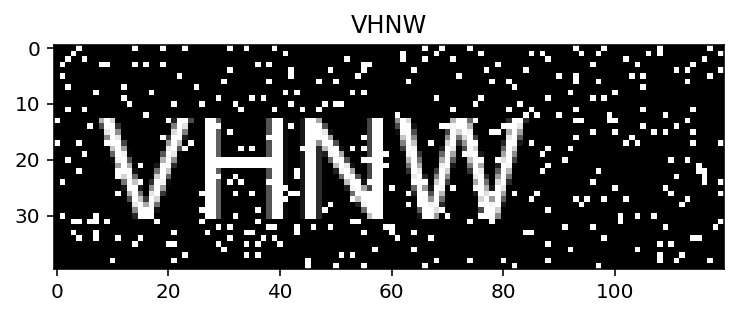

In [4]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

generator = SSOCaptcha()
width = generator.width
height = generator.height
n_len = generator.len
n_class = generator.vocab.size
print(width, height, n_len, n_class)

img, text = generator.get_captcha()

plt.imshow(img)
plt.title(text)

In [5]:
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = SSOCaptcha()
    while True:
        for i in range(batch_size):
            img, text = generator.get_captcha()
            X[i] = img
            for j, ch in enumerate(text):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Text(0.5,1,'LU3R')

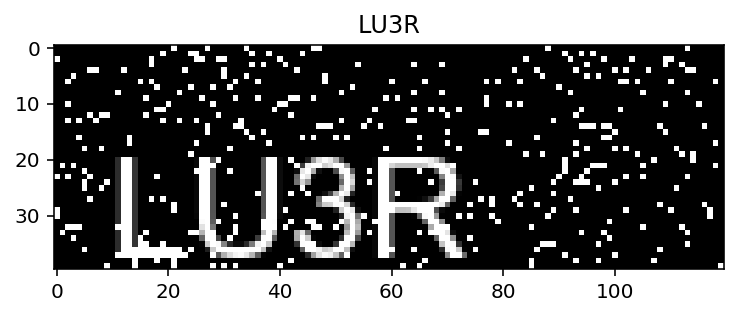

In [6]:
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [7]:
import sys
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Convolution2D(32*2**i, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(input=input_tensor, output=x)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 120, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 120, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 40, 120, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 20, 60, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              #optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.fit_generator(gen(),
                    validation_data=gen(),
                    steps_per_epoch=10000,
                    #steps_per_epoch=51200,
                    epochs=1,
                    #epochs=5,
                    validation_steps=1280)
#model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5, 
#                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/1
10000/10000 [==============================] - 2655s 266ms/step - loss: 2.1303 - c1_loss: 0.4692 - c2_loss: 0.5953 - c3_loss: 0.6015 - c4_loss: 0.4644 - c1_acc: 0.8700 - c2_acc: 0.8390 - c3_acc: 0.8365 - c4_acc: 0.8717 - val_loss: 1.8080 - val_c1_loss: 0.4535 - val_c2_loss: 0.4529 - val_c3_loss: 0.4480 - val_c4_loss: 0.4536 - val_c1_acc: 0.9713 - val_c2_acc: 0.9708 - val_c3_acc: 0.9714 - val_c4_acc: 0.9712


In [1]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='center right')

    plt.show()

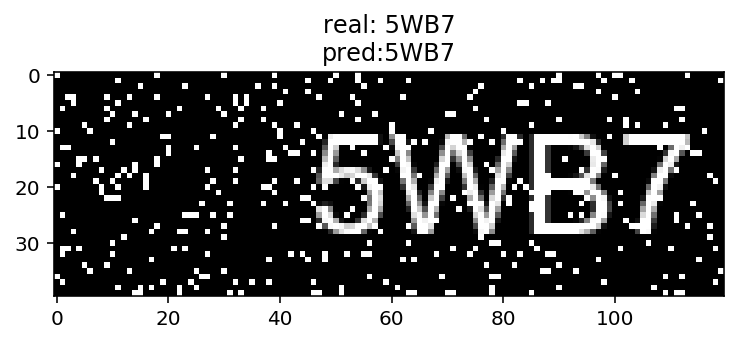

In [43]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [13]:
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
def gen2(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            img, text = getImage()
            text = '1234'
            X[i] = img
            for j, ch in enumerate(text):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

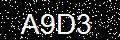

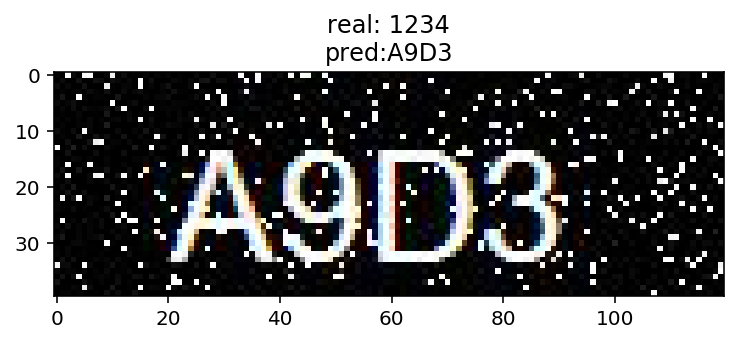

In [72]:
X, y = next(gen2(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [61]:
modelJson = model.to_json()

In [63]:
with open('./model/sso.model.json', 'w') as jsonFile:
    jsonFile.write(modelJson)
model.save_weights('./model/sso.weights.h5')